In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
original_dir = 'D:/Skripsi/Natural Hand Digit'

# Fungsi untuk menghitung total gambar di setiap folder
def count_images(directory):
    total_images = 0
    # os.walk untuk mengiterasi semua subfolder dan file
    for root, dirs, files in os.walk(directory):  
        # Hitung file gambar dengan ekstensi .png, .jpg, atau .jpeg
        image_count = len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))])  
        if image_count > 0:
            # Cetak jumlah gambar per folder
            print(f"Jumlah gambar di folder '{root}': {image_count}")  
        total_images += image_count
    return total_images

# Hitung jumlah total gambar
total = count_images(original_dir)
print(f"Total gambar dalam folder '{original_dir}': {total}")

Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 1 1m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 1 2m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 1 50cm': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 2 1m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 2 2m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 2 50cm': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 3 1m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 3 2m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 3 50cm': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 4 1m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 4 2m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 4 50cm': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\Digit 5 1m': 330
Jumlah gambar di folder 'D:/Skripsi/Natural Hand Digit\D

Contoh Gambar dari Dataset:
Contoh gambar untuk Digit 1 1m:


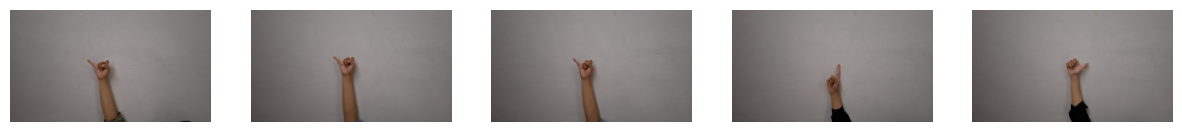

Contoh gambar untuk Digit 1 2m:


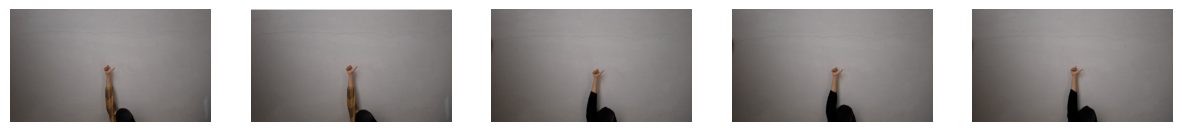

Contoh gambar untuk Digit 1 50cm:


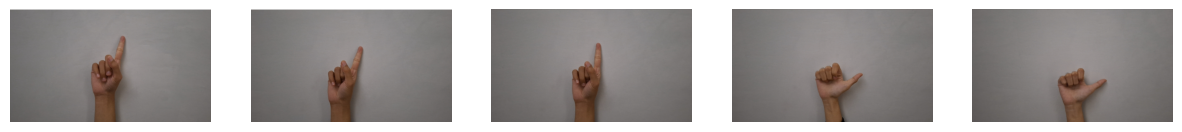

Contoh gambar untuk Digit 2 1m:


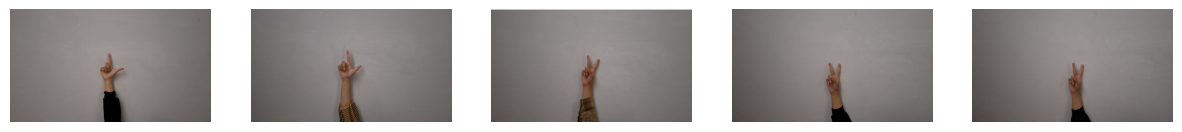

Contoh gambar untuk Digit 2 2m:


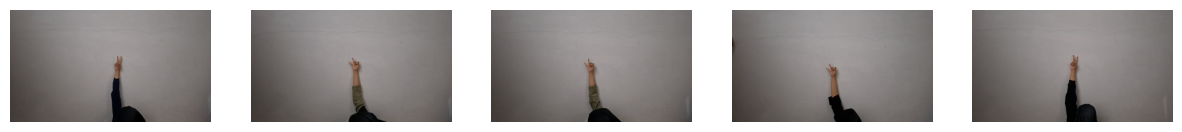

Contoh gambar untuk Digit 2 50cm:


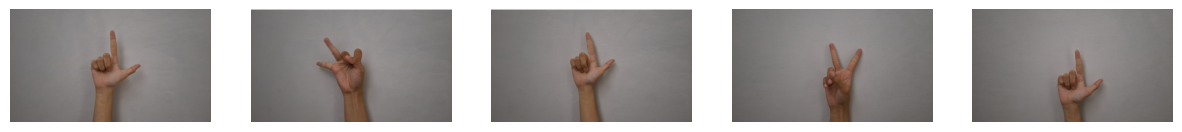

Contoh gambar untuk Digit 3 1m:


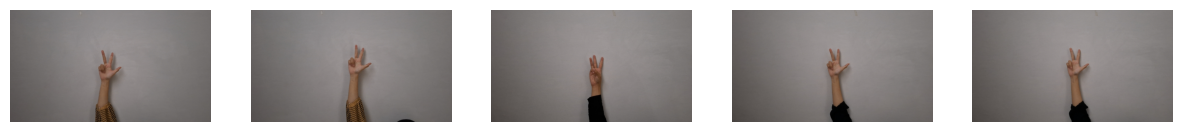

Contoh gambar untuk Digit 3 2m:


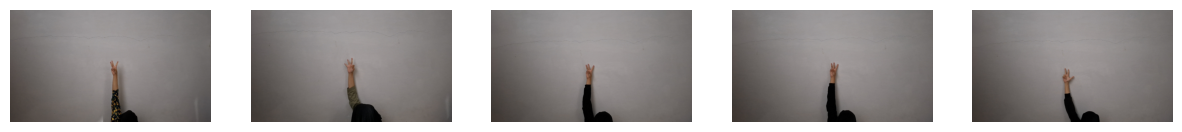

Contoh gambar untuk Digit 3 50cm:


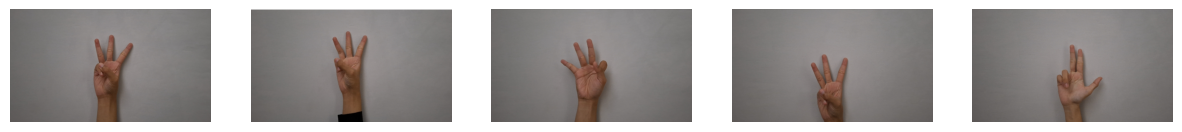

Contoh gambar untuk Digit 4 1m:


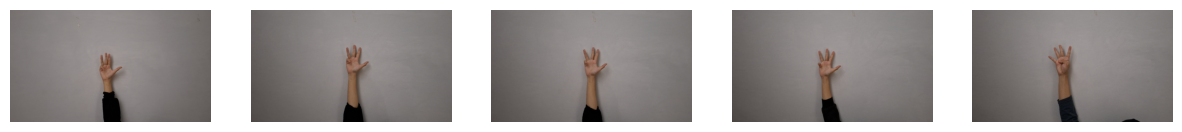

Contoh gambar untuk Digit 4 2m:


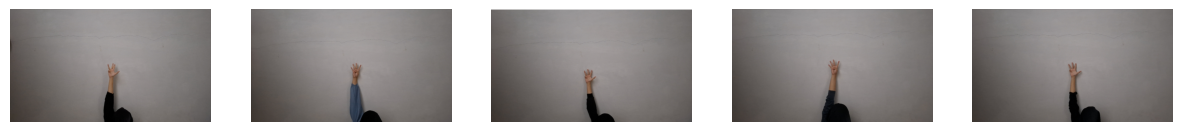

Contoh gambar untuk Digit 4 50cm:


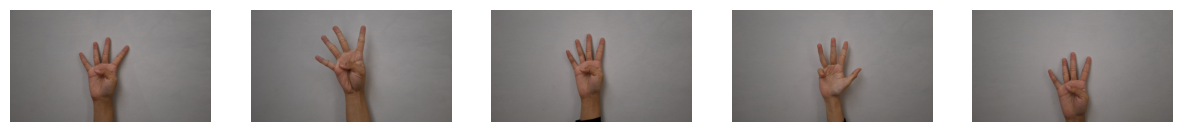

Contoh gambar untuk Digit 5 1m:


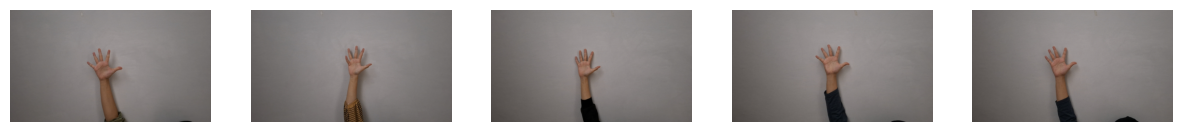

Contoh gambar untuk Digit 5 2m:


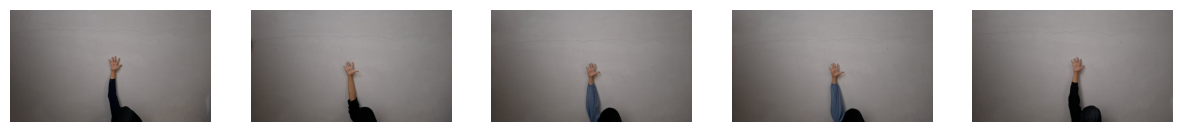

Contoh gambar untuk Digit 5 50cm:


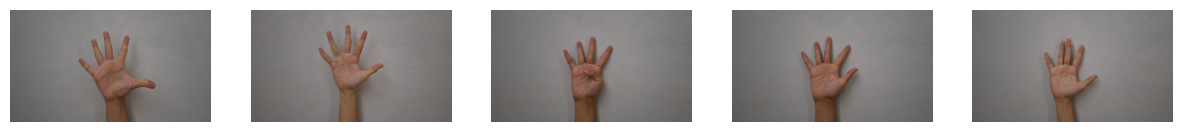

In [4]:
# Fungsi untuk menampilkan gambar sampel per folder (kelas)
def display_sample_images(directory, num_samples=5):
    class_names = sorted(os.listdir(directory))  # Menyortir nama kelas
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Memastikan itu adalah folder
            all_files = [file for file in os.listdir(class_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Hanya gambar
            if len(all_files) > 0:  # Memastikan ada gambar di folder
                sample_files = sorted(random.sample(all_files, min(num_samples, len(all_files))))  # Ambil sampel gambar
                print(f"Contoh gambar untuk {class_name}:")
                plt.figure(figsize=(15, 5))
                for i, file in enumerate(sample_files):
                    img_path = os.path.join(class_path, file)
                    img = mpimg.imread(img_path)
                    plt.subplot(1, num_samples, i + 1)  # Menampilkan dalam satu baris
                    plt.imshow(img)
                    plt.axis('off')  # Menonaktifkan axis untuk gambar
                plt.show()  # Menampilkan gambar dalam satu plot

# Path ke folder dataset
original_dir = 'D:/Skripsi/Natural Hand Digit'

# Tampilkan contoh gambar dari data train
print("Contoh Gambar dari Dataset:")
display_sample_images(original_dir)

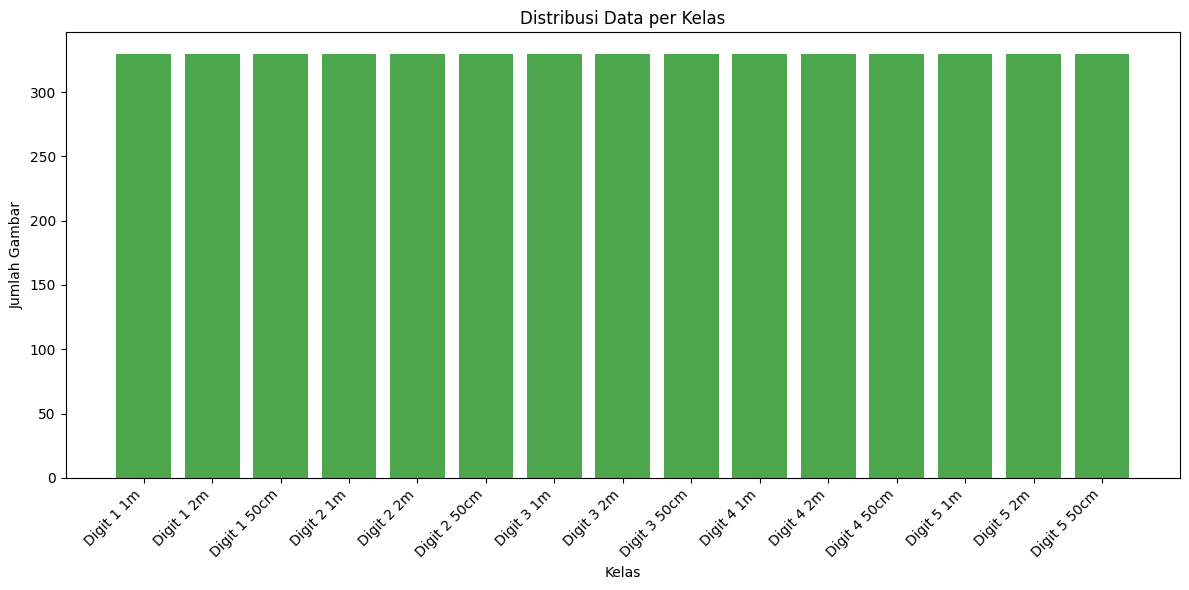

In [5]:
def plot_data_distribution(original_dir):
    # Menghitung jumlah gambar per kelas di seluruh data
    class_counts = {class_name: len(os.listdir(os.path.join(original_dir, class_name)))
                    for class_name in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, class_name))}

    # Ambil nama kelas dan jumlah gambar
    class_names = sorted(class_counts.keys())
    counts = [class_counts[class_name] for class_name in class_names]

    # Plot distribusi data
    x = range(len(class_names))  # Indeks untuk x-axis
    plt.figure(figsize=(12, 6))
    plt.bar(x, counts, color='green', alpha=0.7)

    # Tambahkan label dan judul
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title('Distribusi Data per Kelas')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.tight_layout()

    # Tampilkan plot
    plt.show()

# Panggil fungsi untuk visualisasi distribusi data
plot_data_distribution(original_dir)

# **Pre-processing**

In [6]:
# Konfigurasi dan Path
original_dir = 'D:/Skripsi/Natural Hand Digit'
output_dir = 'D:/Skripsi/Processed Hand Digit'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
train_ratio = 0.8
test_ratio = 0.2

In [7]:
def split_data(original_dir, train_dir, test_dir, train_ratio):
    """Membagi dataset menjadi direktori train dan test."""
    if os.path.exists(output_dir):
        print(f"Menghapus folder yang sudah ada: {output_dir}")
        shutil.rmtree(output_dir)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    print(f"Mulai membagi data dari '{original_dir}'...")
    for subfolder in os.listdir(original_dir):
        class_name = subfolder.split('(')[0].strip()
        class_dir = os.path.join(original_dir, subfolder)
        if not os.path.isdir(class_dir):
            continue

        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        all_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(all_files)
        train_count = int(len(all_files) * train_ratio)

        for i, file in enumerate(all_files):
            src = os.path.join(class_dir, file)
            if i < train_count:
                dst = os.path.join(train_class_dir, file)
            else:
                dst = os.path.join(test_class_dir, file)
            shutil.copy(src, dst)
    print("Dataset berhasil dibagi ke dalam train dan test.")

# Jalankan proses pembagian data
split_data(original_dir, train_dir, test_dir, train_ratio)

Menghapus folder yang sudah ada: D:/Skripsi/Processed Hand Digit
Mulai membagi data dari 'D:/Skripsi/Natural Hand Digit'...
Dataset berhasil dibagi ke dalam train dan test.


In [8]:
# Fungsi untuk menghitung jumlah data dalam folder
def count_files_in_directory(directory):
    total_files = 0
    # Iterasi untuk setiap subfolder dalam directory
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)

        # Lewati jika bukan folder
        if os.path.isdir(subfolder_path):
            # Hitung jumlah file dalam subfolder ini
            files = os.listdir(subfolder_path)
            total_files += len([f for f in files if os.path.isfile(os.path.join(subfolder_path, f))])
    return total_files

# Hitung jumlah file dalam folder train dan test
train_files_count = count_files_in_directory(train_dir)
test_files_count = count_files_in_directory(test_dir)

print(f"Jumlah data di folder train: {train_files_count}")
print(f"Jumlah data di folder test: {test_files_count}")

Jumlah data di folder train: 3960
Jumlah data di folder test: 990


In [9]:
# Fungsi untuk menghitung total gambar, proporsi, dan distribusi kelas
def analyze_dataset(train_dir, test_dir):
    # Inisialisasi variabel
    total_train_images = 0
    total_test_images = 0
    train_class_distribution = {}
    test_class_distribution = {}

    # Hitung distribusi kelas di train
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            class_images = os.listdir(class_path)
            train_class_distribution[class_name] = len(class_images)
            total_train_images += len(class_images)

    # Hitung distribusi kelas di test
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            class_images = os.listdir(class_path)
            test_class_distribution[class_name] = len(class_images)
            total_test_images += len(class_images)

    # Total gambar
    total_images = total_train_images + total_test_images

    # Proporsi data train dan test
    train_ratio = total_train_images / total_images if total_images > 0 else 0
    test_ratio = total_test_images / total_images if total_images > 0 else 0

    # Tampilkan hasil
    print("Total Gambar:")
    print(f"- Total: {total_images}")
    print(f"- Train: {total_train_images}")
    print(f"- Test: {total_test_images}\n")

    print("Proporsi Data:")
    print(f"- Train: {train_ratio:.2%}")
    print(f"- Test: {test_ratio:.2%}\n")

    print("Distribusi Kelas di Train:")
    for class_name, count in train_class_distribution.items():
        print(f"- {class_name}: {count} gambar")

    print("\nDistribusi Kelas di Test:")
    for class_name, count in test_class_distribution.items():
        print(f"- {class_name}: {count} gambar")

# Jalankan analisis dataset
analyze_dataset(train_dir, test_dir)

Total Gambar:
- Total: 4950
- Train: 3960
- Test: 990

Proporsi Data:
- Train: 80.00%
- Test: 20.00%

Distribusi Kelas di Train:
- Digit 1 1m: 264 gambar
- Digit 1 2m: 264 gambar
- Digit 1 50cm: 264 gambar
- Digit 2 1m: 264 gambar
- Digit 2 2m: 264 gambar
- Digit 2 50cm: 264 gambar
- Digit 3 1m: 264 gambar
- Digit 3 2m: 264 gambar
- Digit 3 50cm: 264 gambar
- Digit 4 1m: 264 gambar
- Digit 4 2m: 264 gambar
- Digit 4 50cm: 264 gambar
- Digit 5 1m: 264 gambar
- Digit 5 2m: 264 gambar
- Digit 5 50cm: 264 gambar

Distribusi Kelas di Test:
- Digit 1 1m: 66 gambar
- Digit 1 2m: 66 gambar
- Digit 1 50cm: 66 gambar
- Digit 2 1m: 66 gambar
- Digit 2 2m: 66 gambar
- Digit 2 50cm: 66 gambar
- Digit 3 1m: 66 gambar
- Digit 3 2m: 66 gambar
- Digit 3 50cm: 66 gambar
- Digit 4 1m: 66 gambar
- Digit 4 2m: 66 gambar
- Digit 4 50cm: 66 gambar
- Digit 5 1m: 66 gambar
- Digit 5 2m: 66 gambar
- Digit 5 50cm: 66 gambar


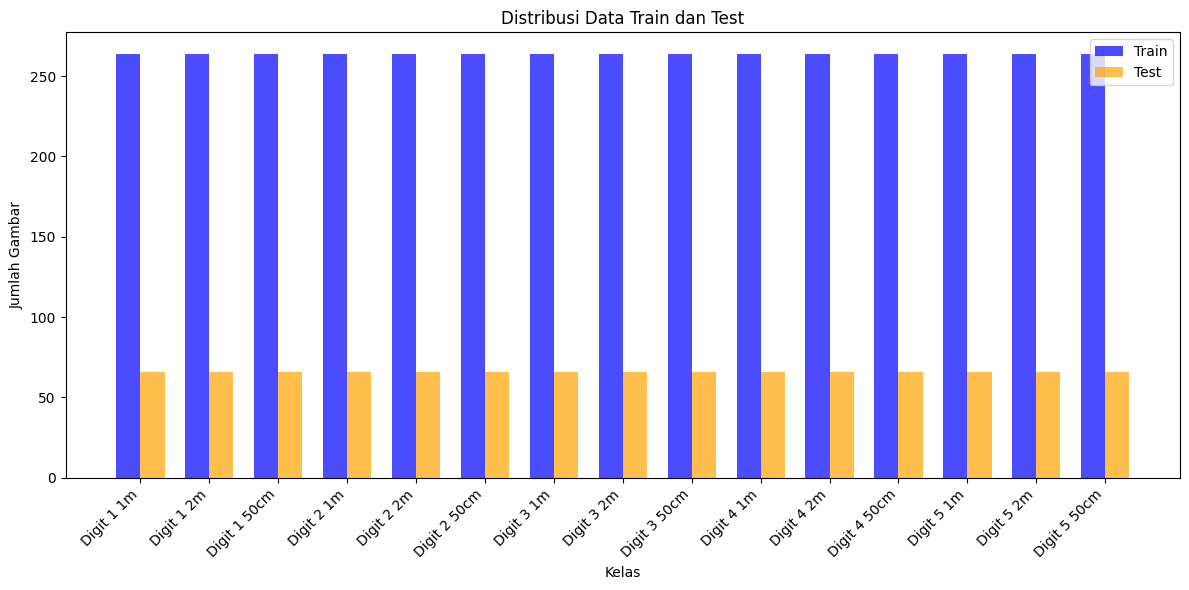

In [10]:
def plot_data_distribution(train_dir, test_dir):
    # Menghitung jumlah gambar per kelas di train dan test
    train_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name)))
                          for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))}

    test_class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name)))
                         for class_name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, class_name))}

    # Gabungkan data train dan test untuk plot
    class_names = sorted(set(train_class_counts.keys()).union(test_class_counts.keys()))
    train_counts = [train_class_counts.get(class_name, 0) for class_name in class_names]
    test_counts = [test_class_counts.get(class_name, 0) for class_name in class_names]

    # Plot distribusi data
    x = range(len(class_names))  # Indeks untuk x-axis
    width = 0.35  # Lebar bar

    plt.figure(figsize=(12, 6))
    plt.bar(x, train_counts, width, label='Train', color='blue', alpha=0.7)
    plt.bar([i + width for i in x], test_counts, width, label='Test', color='orange', alpha=0.7)

    # Tambahkan label dan judul
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title('Distribusi Data Train dan Test')
    plt.xticks([i + width / 2 for i in x], class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Tampilkan plot
    plt.show()

# Panggil fungsi untuk visualisasi distribusi data
plot_data_distribution(train_dir, test_dir)

In [11]:
# Image data generator dengan augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())

print("Data generator berhasil disiapkan.")

Found 3960 images belonging to 15 classes.
Found 990 images belonging to 15 classes.
Data generator berhasil disiapkan.


## **Pembuatan Model**

In [12]:
def build_transfer_learning_model(model_name, num_classes):
    """Membuat model menggunakan ResNet50V2."""
    if model_name.lower() == 'resnet50v2':
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    else:
        raise ValueError("Nama model  'ResNet50V2' tidak didukung")

    # Bekukan (freeze) layer dasar agar tidak dilatih ulang
    for layer in base_model.layers:
        layer.trainable = False

    # Tambahkan layer baru di atas model dasar
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Buat model akhir
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
# Pilih model: 'VGG16' atau 'ResNet50V2'
model = build_transfer_learning_model('ResNet50V2', num_classes)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [14]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

print("Pelatihan model selesai.")

Epoch 1/100


124/124 [==============================] - 667s 5s/step - loss: 2.3539 - accuracy: 0.2328 - val_loss: 1.4850 - val_accuracy: 0.5202
Epoch 2/100
124/124 [==============================] - 644s 5s/step - loss: 1.6403 - accuracy: 0.4177 - val_loss: 1.1280 - val_accuracy: 0.5980
Epoch 3/100
124/124 [==============================] - 645s 5s/step - loss: 1.4109 - accuracy: 0.4879 - val_loss: 0.9512 - val_accuracy: 0.6727
Epoch 4/100
124/124 [==============================] - 644s 5s/step - loss: 1.2601 - accuracy: 0.5323 - val_loss: 0.8794 - val_accuracy: 0.6838
Epoch 5/100
124/124 [==============================] - 653s 5s/step - loss: 1.1626 - accuracy: 0.5639 - val_loss: 0.7972 - val_accuracy: 0.7121
Epoch 6/100
124/124 [==============================] - 699s 6s/step - loss: 1.0773 - accuracy: 0.5952 - val_loss: 0.7246 - val_accuracy: 0.7091
Epoch 7/100
124/124 [==============================] - 668s 5s/step - loss: 0.9845 - accuracy: 0.6210 - val_loss: 0.6633 - val_accurac

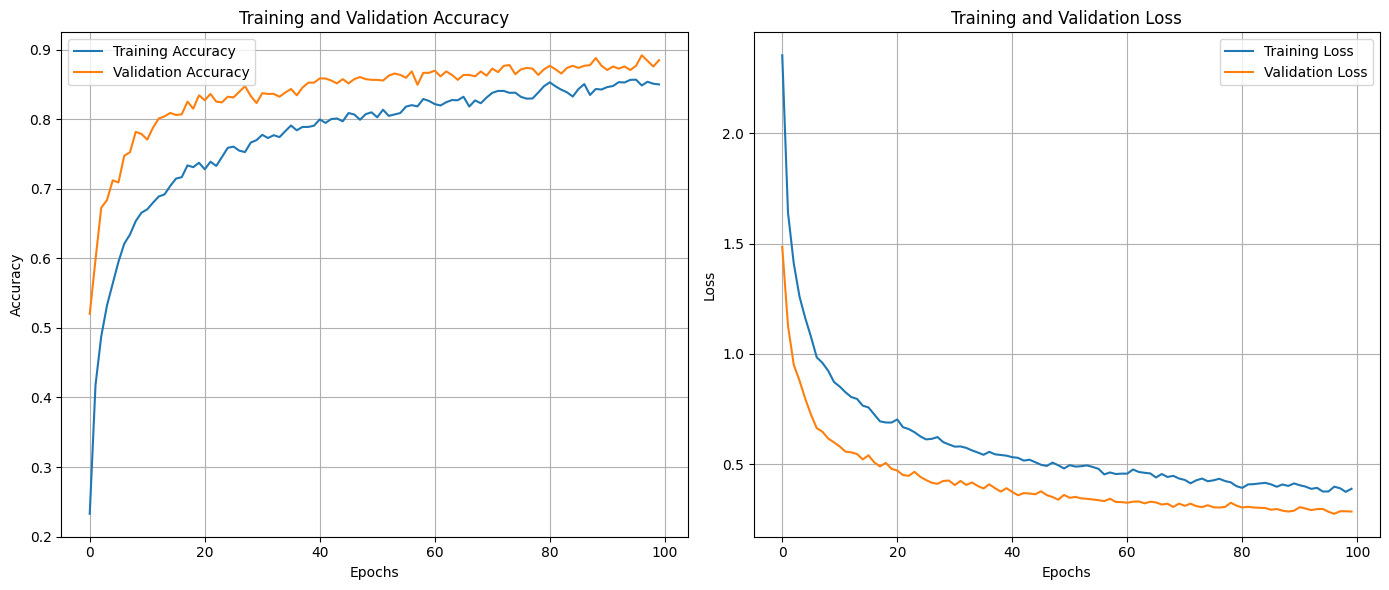


--- Evaluasi Model ---
31/31 [==============================] - 132s 4s/step
Classification Report:
              precision    recall  f1-score   support

  Digit 1 1m       0.94      0.98      0.96        66
  Digit 1 2m       0.89      0.88      0.89        66
Digit 1 50cm       0.99      1.00      0.99        66
  Digit 2 1m       0.95      0.94      0.95        66
  Digit 2 2m       0.61      0.74      0.67        66
Digit 2 50cm       0.98      0.98      0.98        66
  Digit 3 1m       0.92      0.85      0.88        66
  Digit 3 2m       0.66      0.59      0.62        66
Digit 3 50cm       0.93      0.97      0.95        66
  Digit 4 1m       0.80      0.89      0.84        66
  Digit 4 2m       0.87      0.73      0.79        66
Digit 4 50cm       0.97      0.91      0.94        66
  Digit 5 1m       0.97      0.89      0.93        66
  Digit 5 2m       0.85      0.92      0.88        66
Digit 5 50cm       1.00      0.98      0.99        66

    accuracy                     

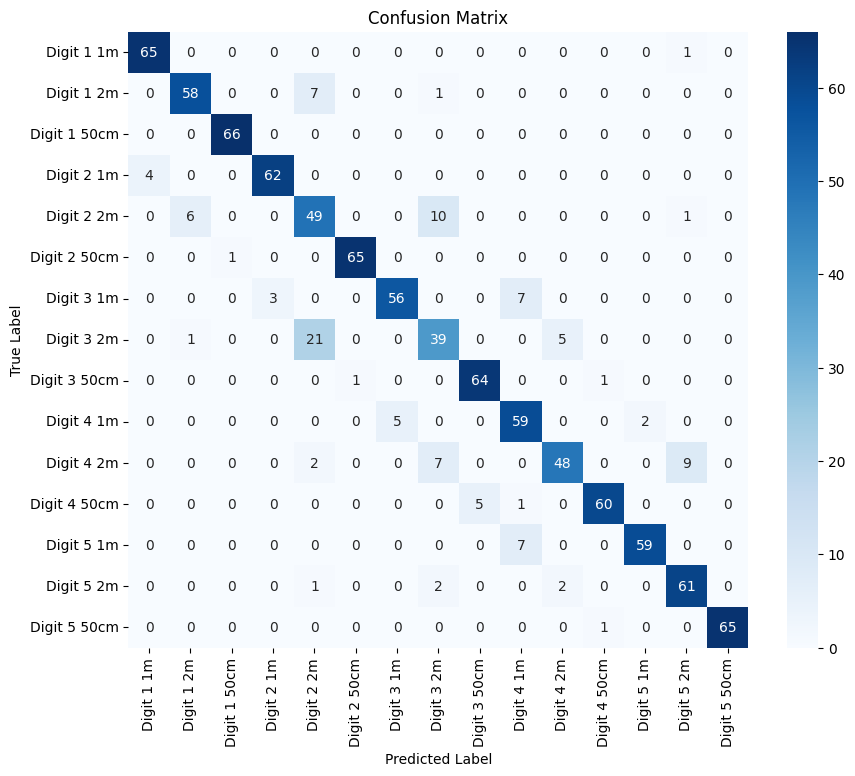

In [19]:
# @title 5. Evaluasi dan Visualisasi Hasil
def plot_training_history(history):
    """Visualisasi akurasi dan loss selama training."""
    plt.figure(figsize=(14, 6))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_generator, class_labels):
    """Menghitung dan memvisualisasikan metrik evaluasi model."""
    print("\n--- Evaluasi Model ---")

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Hitung dan cetak Classification Report
    print("Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
    print(report)

    # Hitung Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasi Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Visualisasi dan Evaluasi
plot_training_history(history)
evaluate_model(model, test_generator, class_labels)

In [20]:
# Menyimpan Model yang Sudah Dilatih
model.save('D:\Skripsi\digit_recognition_model.h5')
print("Model berhasil disimpan.")

C:\Users\hp_fq\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model berhasil disimpan.


Model berhasil dimuat.
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 1 1m/Screenshot_20241108_032341_Gallery.jpg
1/1 [==============================] - 4s 4s/step
Prediksi: Digit 1 1m
Keyakinan (Confidence): 95.97%


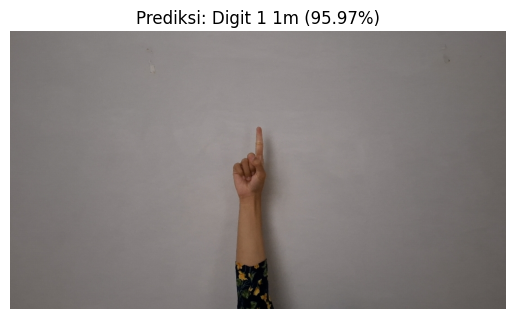

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 1 2m/Screenshot_20241108_144643_Gallery.jpg
1/1 [==============================] - 0s 330ms/step
Prediksi: Digit 1 2m
Keyakinan (Confidence): 99.01%


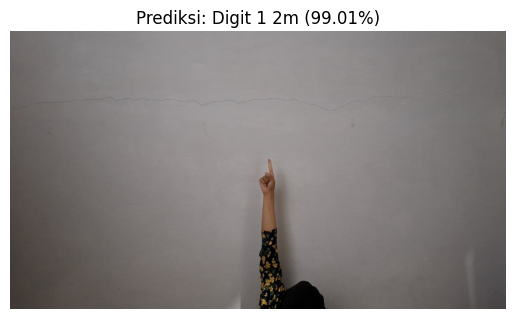

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 1 50cm/Screenshot_20241107_211220_Gallery.jpg
1/1 [==============================] - 0s 259ms/step
Prediksi: Digit 1 50cm
Keyakinan (Confidence): 99.93%


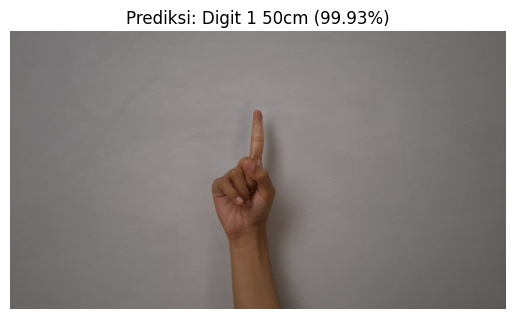

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 2 1m/Screenshot_20241108_032611_Gallery.jpg
1/1 [==============================] - 0s 286ms/step
Prediksi: Digit 2 1m
Keyakinan (Confidence): 91.08%


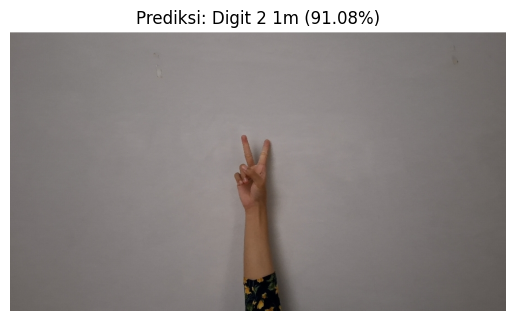

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 2 2m/Screenshot_20241108_144526_Gallery.jpg
1/1 [==============================] - 0s 289ms/step
Prediksi: Digit 2 2m
Keyakinan (Confidence): 45.94%


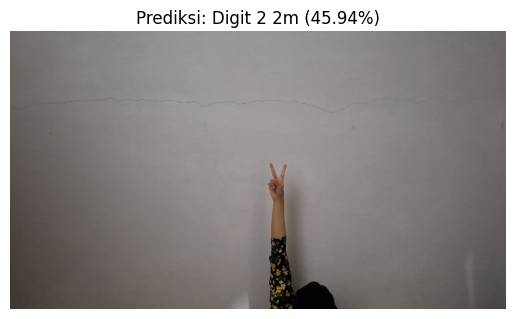

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 2 50cm/Screenshot_20241107_211036_Gallery.jpg
1/1 [==============================] - 0s 293ms/step
Prediksi: Digit 2 50cm
Keyakinan (Confidence): 94.70%


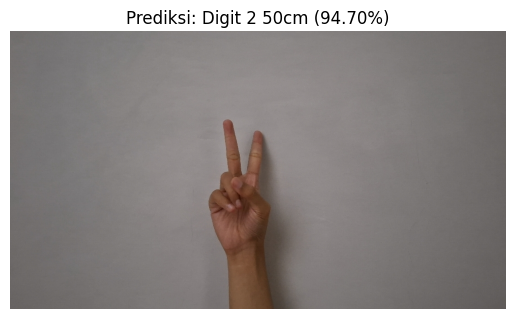

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 3 1m/Screenshot_20241108_032713_Gallery.jpg
1/1 [==============================] - 0s 298ms/step
Prediksi: Digit 3 1m
Keyakinan (Confidence): 89.36%


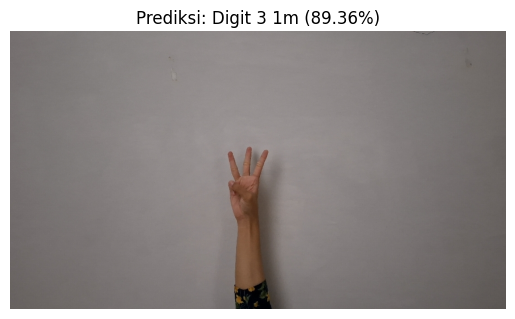

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 3 2m/Screenshot_20241108_144717_Gallery.jpg
1/1 [==============================] - 0s 235ms/step
Prediksi: Digit 2 2m
Keyakinan (Confidence): 54.50%


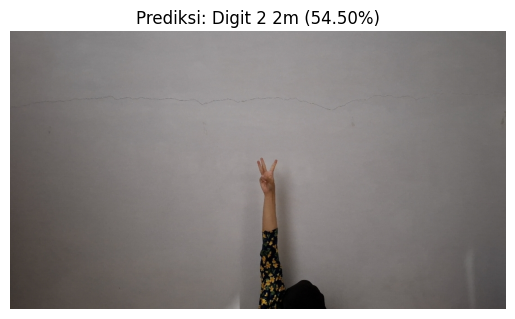

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 3 50cm/Screenshot_20241107_211240_Gallery.jpg
1/1 [==============================] - 0s 208ms/step
Prediksi: Digit 3 50cm
Keyakinan (Confidence): 99.65%


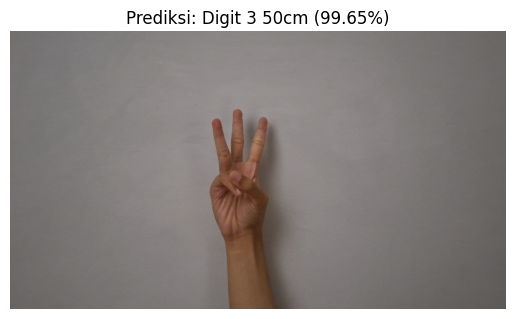

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 4 1m/Screenshot_20241108_032723_Gallery.jpg
1/1 [==============================] - 0s 243ms/step
Prediksi: Digit 4 1m
Keyakinan (Confidence): 98.28%


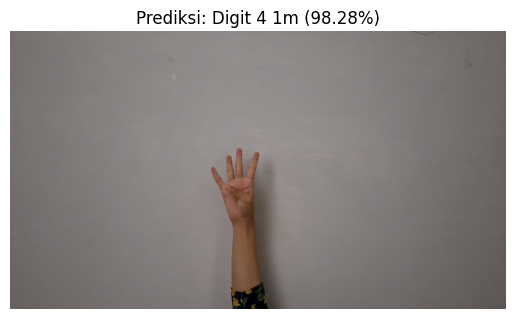

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 4 2m/Screenshot_20241108_144542_Gallery.jpg
1/1 [==============================] - 0s 245ms/step
Prediksi: Digit 4 2m
Keyakinan (Confidence): 65.87%


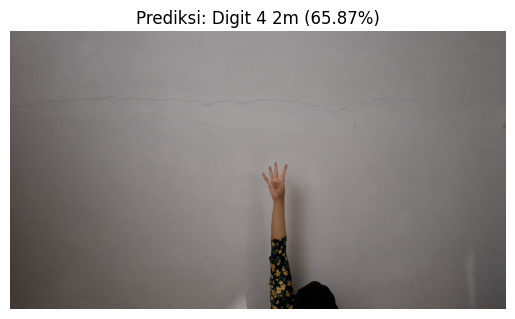

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 4 50cm/Screenshot_20241107_211300_Gallery.jpg
1/1 [==============================] - 0s 228ms/step
Prediksi: Digit 4 50cm
Keyakinan (Confidence): 86.54%


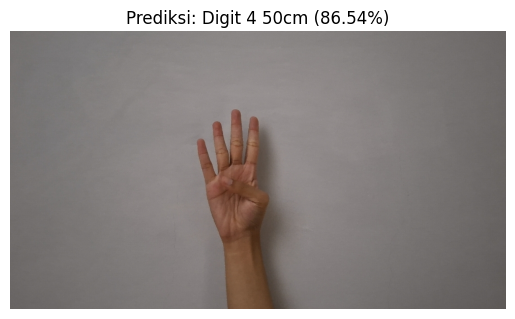

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 5 1m/Screenshot_20241108_032831_Gallery.jpg
1/1 [==============================] - 0s 248ms/step
Prediksi: Digit 5 1m
Keyakinan (Confidence): 99.96%


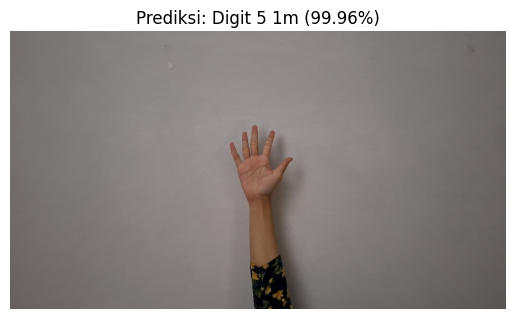

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 5 2m/Screenshot_20241108_144732_Gallery.jpg
1/1 [==============================] - 0s 199ms/step
Prediksi: Digit 5 2m
Keyakinan (Confidence): 74.24%


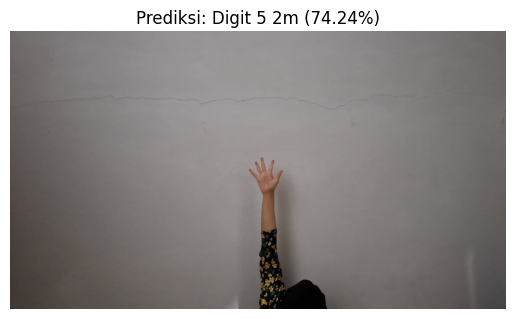

------------------------------------------
Menganalisis gambar: D:/Skripsi/Natural Hand Digit/Digit 5 50cm/Screenshot_20241107_211102_Gallery.jpg
1/1 [==============================] - 0s 303ms/step
Prediksi: Digit 5 50cm
Keyakinan (Confidence): 99.73%


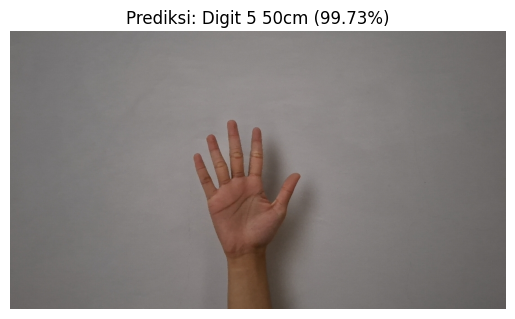

------------------------------------------


In [29]:
# Digit 1 1m
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Path ke model yang sudah disimpan
model_path = 'D:\Skripsi\digit_recognition_model.h5'

# Memuat model
try:
    loaded_model = load_model(model_path)
    print("Model berhasil dimuat.")
except IOError:
    print("Error: Model tidak ditemukan. Pastikan Anda sudah menjalankan sel penyimpanan model.")
    # Stop execution if model is not found
    raise SystemExit(1)

# Fungsi untuk memuat dan memproses gambar
def preprocess_new_image(img_path, target_size=(224, 224)):
    """Memuat dan memproses gambar agar siap untuk prediksi."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Tambahkan dimensi batch
    img_array /= 255.0 # Normalisasi
    return img_array

# Fungsi untuk melakukan prediksi
def predict_digit(img_path, model, class_labels):
    """Memprediksi angka dari sebuah gambar baru."""
    processed_image = preprocess_new_image(img_path)

    # Jalankan prediksi
    predictions = model.predict(processed_image)

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Dapatkan nama kelas
    predicted_label = class_labels[predicted_class_index]

    # Dapatkan probabilitas
    confidence = np.max(predictions) * 100

    print(f"Prediksi: {predicted_label}")
    print(f"Keyakinan (Confidence): {confidence:.2f}%")

    # Tampilkan gambar
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Contoh penggunaan
# Ganti path ini dengan path gambar angka baru yang ingin Anda deteksi
new_image_path = [
    'D:/Skripsi/Natural Hand Digit/Digit 1 1m/Screenshot_20241108_032341_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 1 2m/Screenshot_20241108_144643_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 1 50cm/Screenshot_20241107_211220_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 2 1m/Screenshot_20241108_032611_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 2 2m/Screenshot_20241108_144526_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 2 50cm/Screenshot_20241107_211036_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 3 1m/Screenshot_20241108_032713_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 3 2m/Screenshot_20241108_144717_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 3 50cm/Screenshot_20241107_211240_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 4 1m/Screenshot_20241108_032723_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 4 2m/Screenshot_20241108_144542_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 4 50cm/Screenshot_20241107_211300_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 5 1m/Screenshot_20241108_032831_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 5 2m/Screenshot_20241108_144732_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 5 50cm/Screenshot_20241107_211102_Gallery.jpg'
    ]
for path in new_image_path:
    print(f"Menganalisis gambar: {path}")
    predict_digit(path, loaded_model, class_labels)
    print("------------------------------------------")

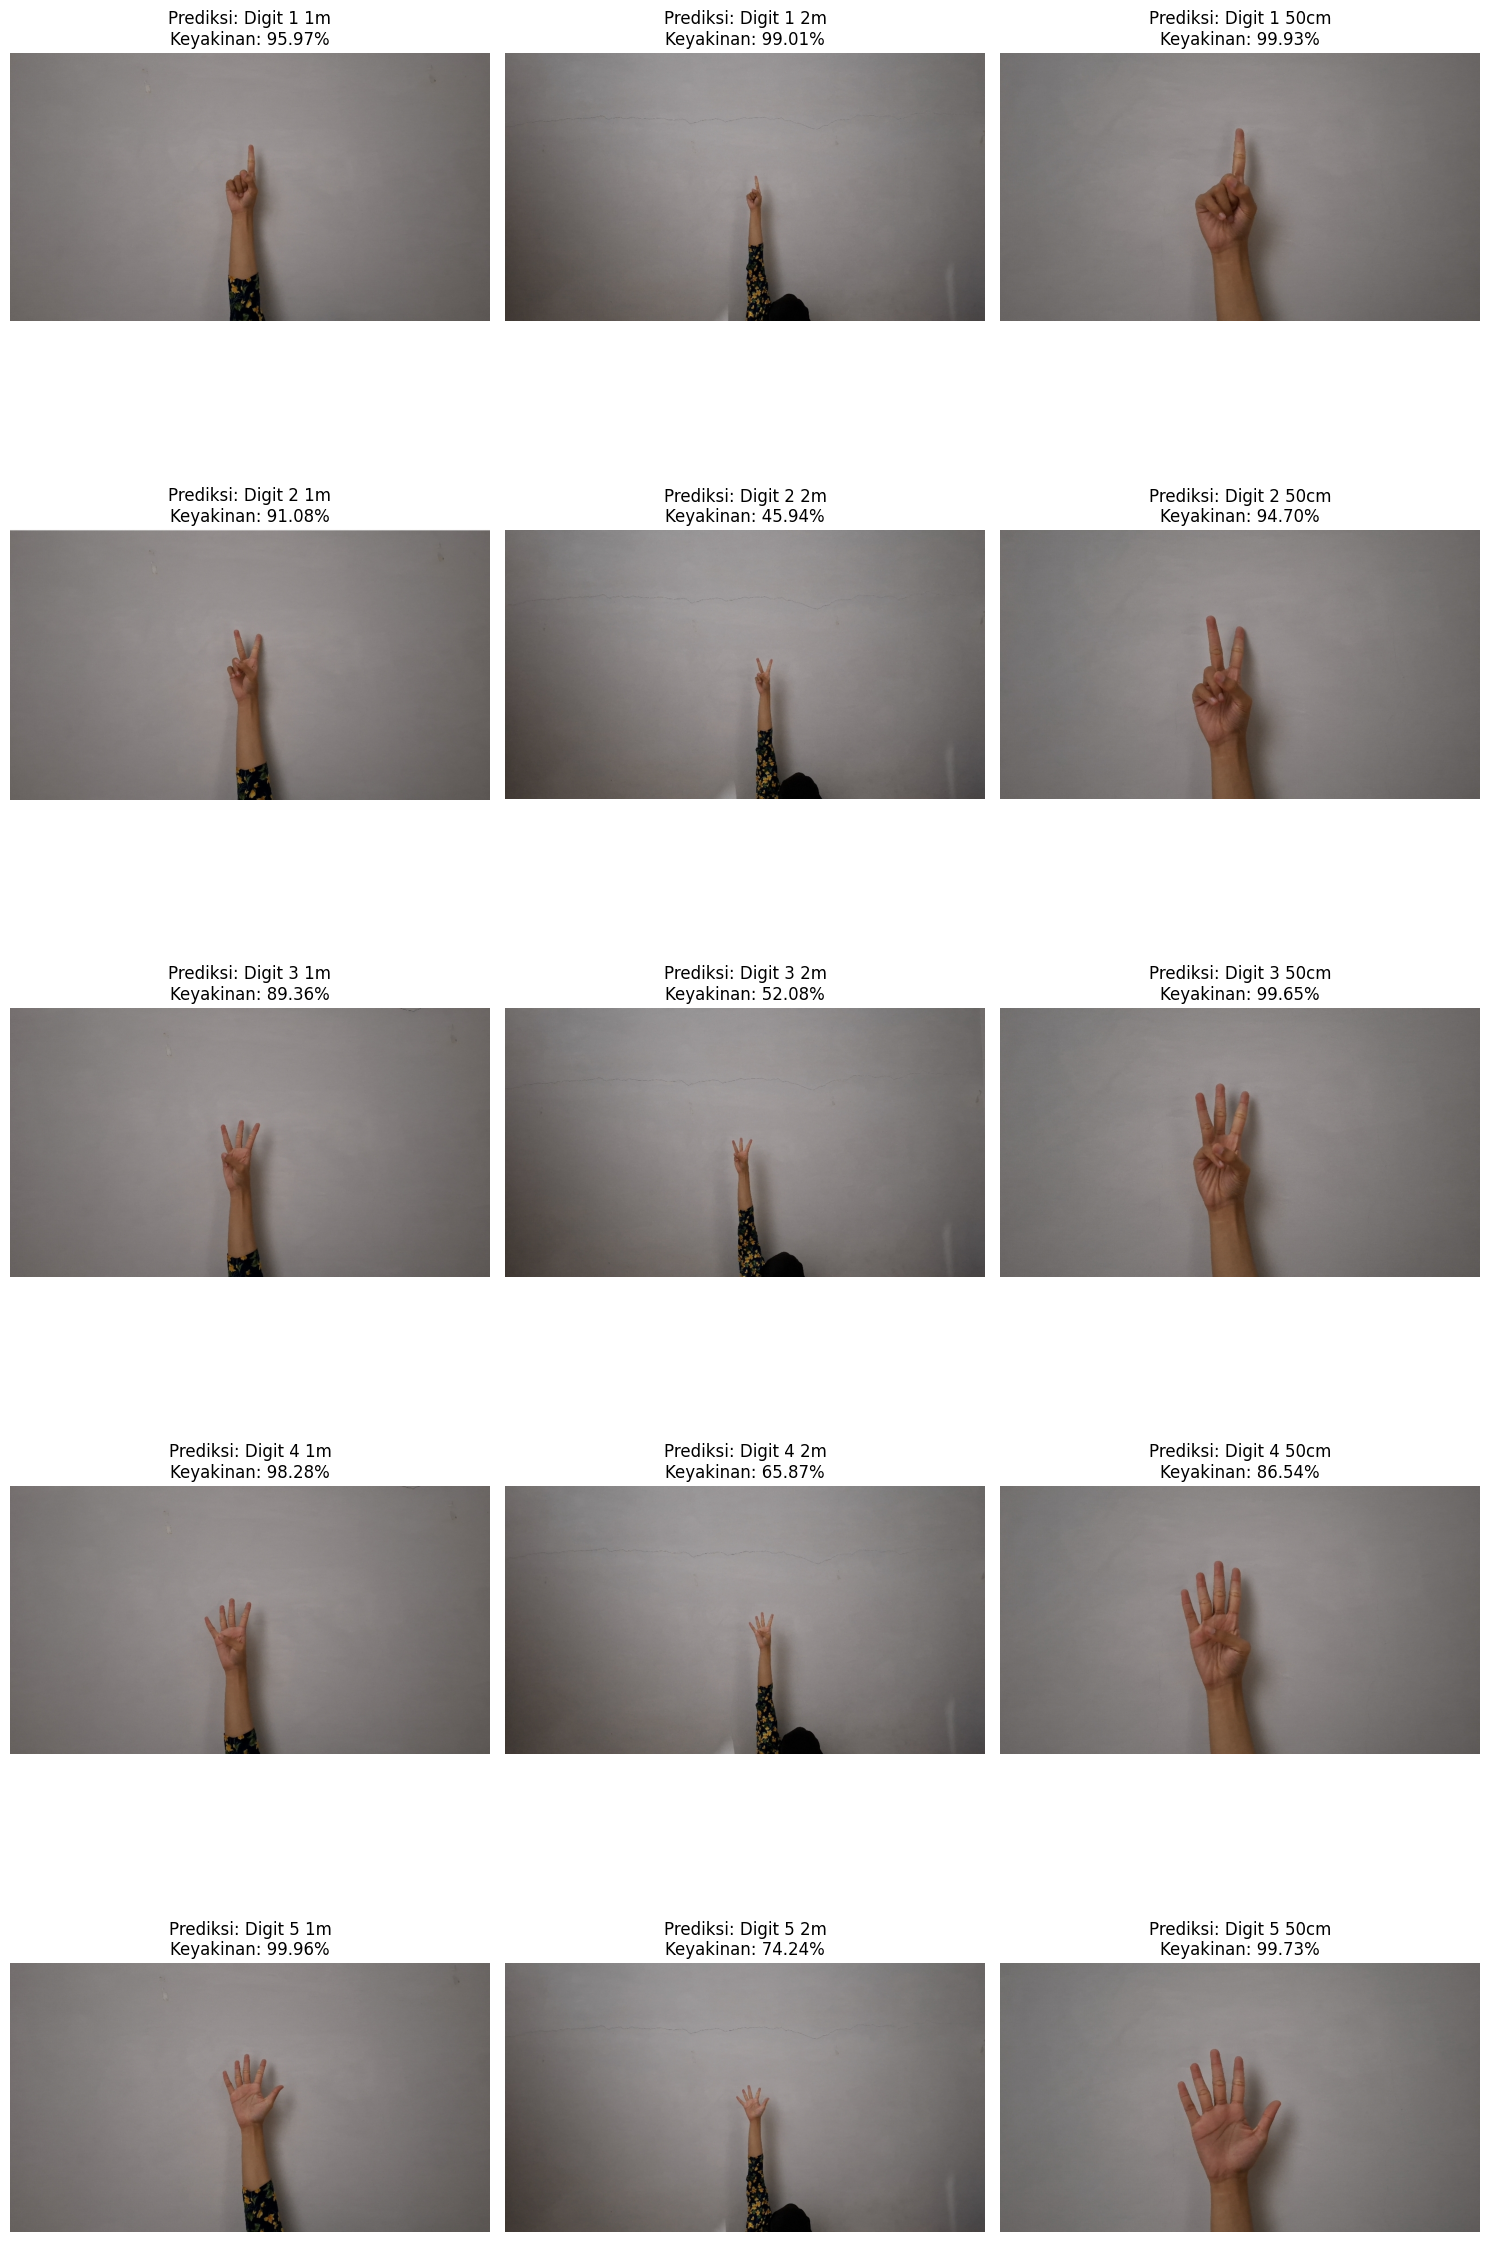

In [30]:
import matplotlib.pyplot as plt
import math

# Pastikan Anda sudah mengimpor semua library yang diperlukan di bagian atas skrip
# dari tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# import numpy as np
# (dan lain-lain)

# ... (bagian definisi model dan fungsi preprocess_new_image tetap sama)

# Ganti fungsi predict_digit() dengan yang ini.
# Fungsi ini tidak lagi memanggil plt.show()
def predict_and_get_result(img_path, model, class_labels):
    processed_image = preprocess_new_image(img_path)
    predictions = model.predict(processed_image, verbose=0)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class_index]
    confidence = np.max(predictions) * 100
    return predicted_label, confidence

# Contoh penggunaan
new_image_path = [
    'D:/Skripsi/Natural Hand Digit/Digit 1 1m/Screenshot_20241108_032341_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 1 2m/Screenshot_20241108_144643_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 1 50cm/Screenshot_20241107_211220_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 2 1m/Screenshot_20241108_032611_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 2 2m/Screenshot_20241108_144526_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 2 50cm/Screenshot_20241107_211036_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 3 1m/Screenshot_20241108_032713_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 3 2m/Screenshot_20241108_144907_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 3 50cm/Screenshot_20241107_211240_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 4 1m/Screenshot_20241108_032723_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 4 2m/Screenshot_20241108_144542_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 4 50cm/Screenshot_20241107_211300_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 5 1m/Screenshot_20241108_032831_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 5 2m/Screenshot_20241108_144732_Gallery.jpg',
    'D:/Skripsi/Natural Hand Digit/Digit 5 50cm/Screenshot_20241107_211102_Gallery.jpg'
    ]

# Tentukan jumlah kolom
num_cols = 3
num_images = len(new_image_path)
# Hitung jumlah baris yang dibutuhkan
num_rows = math.ceil(num_images / num_cols) 

# Buat figure dan axes (subplot)
# figsize dapat diatur sesuai kebutuhan
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Jika hanya ada satu baris, axes akan menjadi array 1D. 
# Kita pastikan axes selalu 2D untuk mempermudah looping
if num_rows == 1 and num_cols > 1:
    axes = axes.reshape(1, -1)
elif num_cols == 1 and num_rows > 1:
    axes = axes.reshape(-1, 1)
elif num_rows == 1 and num_cols == 1:
    axes = np.array([[axes]])
    
# Loop melalui setiap path gambar dan tampilkan di subplot
for i, img_path in enumerate(new_image_path):
    # Hitung posisi baris dan kolom untuk subplot saat ini
    row = i // num_cols
    col = i % num_cols

    # Lakukan prediksi
    predicted_label, confidence = predict_and_get_result(img_path, loaded_model, class_labels)

    # Muat gambar asli untuk ditampilkan
    img = image.load_img(img_path)
    
    # Tampilkan gambar di subplot yang sesuai
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Prediksi: {predicted_label}\nKeyakinan: {confidence:.2f}%")
    axes[row, col].axis('off')

# Hapus subplot yang kosong (jika ada)
for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

# Sesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
# Tampilkan semua gambar dalam satu jendela
plt.show()